In this project, we combined email datasets from two sources for phishing detection. The combined dataset (before cleaning) includes :

Enron (Benign):
~15,000 non-phishing emails extracted from the Enron email corpus — widely regarded as a reliable dataset for legitimate communications.

Kaggle Phishing Dataset:
~10,000 phishing emails collected from Kaggle's phishing email dataset, labeled as phishing (label = 1).


## 1.Preprocessing Steps

Standardized column names and encodings.

Added a label column:

1 for phishing

0 for benign (Enron)

Concatenated all datasets with a Source column.

Checked and removed duplicate emails (based on the Message field), even if they came from different sources.

Saved final result as combined_raw_dataset.csv.


In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install seaborn


In [3]:
!pip install nltk

In [4]:
!pip install wordcloud

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from wordcloud import WordCloud
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/azaleadj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/azaleadj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/azaleadj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/azaleadj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
import os


os.chdir("/Users/azaleadj/Desktop/Uvic/summer/592/project/Summer-2025-ECE-597-Group4/DataPreprocessing")


print("Current directory:", os.getcwd())


Current directory: /Users/azaleadj/Desktop/Uvic/summer/592/project/Summer-2025-ECE-597-Group4/DataPreprocessing


Preprocessing Steps
Standardized column names and encodings.

Added a label column:

1 for phishing

0 for benign (Enron)

Concatenated all datasets with a Source column.

Checked and removed duplicate emails (based on the Message field), even if they came from different sources.

Saved final result as combined_raw_dataset.csv.


In [7]:
import pandas as pd

# read every CSV file
df_ceas = pd.read_csv("CEAS_08.csv")
df_enron = pd.read_csv("Enron.csv")
df_ling = pd.read_csv("Ling.csv")
df_nazario = pd.read_csv("Nazario.csv")
df_nigerian = pd.read_csv("Nigerian_Fraud.csv")
df_phishing = pd.read_csv("phishing_email.csv")
df_spamassassin = pd.read_csv("SpamAssasin.csv")

# check every DataFrame culumn
print("CEAS_08:", df_ceas.columns.tolist())
print("Enron:", df_enron.columns.tolist())
print("Ling:", df_ling.columns.tolist())
print("Nazario:", df_nazario.columns.tolist())
print("Nigerian_Fraud:", df_nigerian.columns.tolist())
print("phishing_email:", df_phishing.columns.tolist())
print("SpamAssasin:", df_spamassassin.columns.tolist())


CEAS_08: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
Enron: ['subject', 'body', 'label']
Ling: ['subject', 'body', 'label']
Nazario: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
Nigerian_Fraud: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
phishing_email: ['text_combined', 'label']
SpamAssasin: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']


In [8]:
# "For the first six datasets: concatenate the subject and body fields."

def combine_subject_body(df):
    return df['subject'].fillna('') + ' ' + df['body'].fillna('')

# Ensure all datasets have only two columns: Message and label.
df_ceas_clean = pd.DataFrame({
    'Message': combine_subject_body(df_ceas),
    'label': df_ceas['label']
})

df_enron_clean = pd.DataFrame({
    'Message': combine_subject_body(df_enron),
    'label': df_enron['label']
})

df_ling_clean = pd.DataFrame({
    'Message': combine_subject_body(df_ling),
    'label': df_ling['label']
})

df_nazario_clean = pd.DataFrame({
    'Message': combine_subject_body(df_nazario),
    'label': df_nazario['label']
})

df_nigerian_clean = pd.DataFrame({
    'Message': combine_subject_body(df_nigerian),
    'label': df_nigerian['label']
})

df_spamassassin_clean = pd.DataFrame({
    'Message': combine_subject_body(df_spamassassin),
    'label': df_spamassassin['label']
})

# rename text_combined
df_phishing_clean = pd.DataFrame({
    'Message': df_phishing['text_combined'],
    'label': df_phishing['label']
})


In [10]:
all_emails_df = pd.concat([
    df_ceas_clean,
    df_enron_clean,
    df_ling_clean,
    df_nazario_clean,
    df_nigerian_clean,
    df_spamassassin_clean,
    df_phishing_clean
], ignore_index=True)


In [11]:
all_emails_df.head()

,Message,label
0,"Never agree to be a loser Buck up, your troubl...",1
1,Befriend Jenna Jameson \nUpgrade your sex and ...,1
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,0
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1


In [12]:
before = all_emails_df.shape[0]
all_emails_df.drop_duplicates(subset='Message', inplace=True)
after = all_emails_df.shape[0]
print(f"deleted duplicated emails: {before - after} ")

deleted duplicated emails: 420 


In [13]:
print(all_emails_df.shape)
print(all_emails_df['label'].value_counts())

(164552, 2)
label
1    85729
0    78823
Name: count, dtype: int64


In [14]:
import re
def clean_text(text):
    text = text.lower()
    # keep URL、email、HTML,number,$,@,:/
    
    text = re.sub(r'[^\x00-\x7f]', ' ', text)              # delete non ASCII
    text = re.sub(r'\b[a-z]{1,2}\b', '', text)             # delet short word
    text = re.sub(r'[^a-z0-9\s@$:/]', '', text)               
    text = re.sub(r'\s+', ' ', text).strip()
    return text



   


In [15]:
all_emails_df['Clean_Message'] = all_emails_df['Message'].apply(clean_text)



In [16]:
all_emails_df[['Message', 'Clean_Message', 'label']].head()


,Message,Clean_Message,label
0,"Never agree to be a loser Buck up, your troubl...",never agree loser buck your troubles caused sm...,1
1,Befriend Jenna Jameson \nUpgrade your sex and ...,befriend jenna jameson upgrade your sex and pl...,1
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,cnncom daily top 10 the daily top 10 from cnnc...,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,: svn commit: r619753 /spamassassin/trunk: lib...,0
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,specialpricespharmmoreinfo welcomefastshipping...,1


In [17]:

from sklearn.utils import shuffle

# shuffle
all_emails_df = shuffle(all_emails_df, random_state=42).reset_index(drop=True)

In [18]:
all_emails_df.head()

,Message,label,Clean_Message
0,[UAI] CFP (extended deadline): Workshop on Joi...,0,uai cfp extended deadline: workshop joint infe...
1,laverne norrix dxzflagshipclaxsoncomuy increas...,1,laverne norrix dxzflagshipclaxsoncomuy increas...
2,Saving money on your meds has never been easie...,1,saving money your meds has never been easier z...
3,scott lipcon slipconmerceanet updated latest c...,0,scott lipcon slipconmerceanet updated latest c...
4,clear benefits creative design lt really hard ...,1,clear benefits creative design really hard rec...


In [19]:
all_emails_df.to_csv("combined_raw_dataset.csv", index=False)


In [20]:
# View label distribution (counts and proportions)
label_counts = all_emails_df['label'].value_counts()
label_ratio = all_emails_df['label'].value_counts(normalize=True)

print("Label count distribution:\n", label_counts)
print("\nLabel proportion distribution:\n", label_ratio)


Label count distribution:
 label
1    85729
0    78823
Name: count, dtype: int64

Label proportion distribution:
 label
1    0.520984
0    0.479016
Name: proportion, dtype: float64


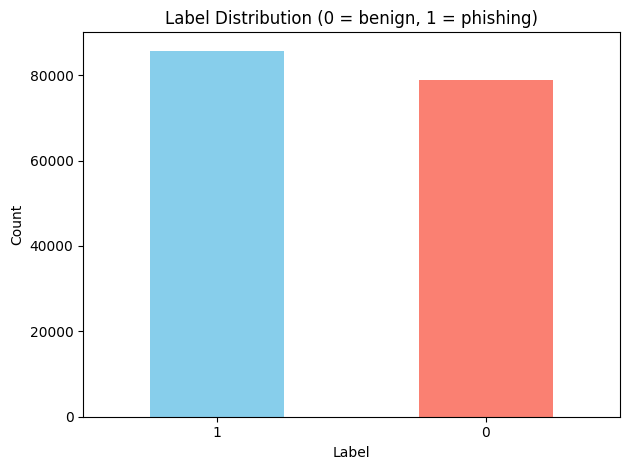

In [21]:


label_counts = all_emails_df['label'].value_counts()
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Label Distribution (0 = benign, 1 = phishing)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
